# Cell 1: Install packages

In [1]:
!pip -q install ultralytics timm tqdm pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.9 MB/s eta 0:00:00


# Cell 2: Import and setup

In [2]:
import os, json, yaml, math, gc, random, shutil, contextlib
from pathlib import Path
from PIL import Image

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.auto import tqdm
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
print("Device:", device, "| torch", torch.__version__)

def autocast_ctx():
    return torch.autocast(device_type="cuda", enabled=True) if device=="cuda" else contextlib.nullcontext()


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Device: cuda | torch 2.6.0+cu124


# Cell 3: Path setup

In [3]:
BASE  = Path("/kaggle/input/assignment-mango/mango")
WORK  = Path("/kaggle/working/mango_ssl_yolo12_dinov2")
SPLIT = WORK / "yolo_split"
DATA  = WORK / "data_mango.yaml"
SSL_W = WORK / "backbone_ssl_yolo12_dinov2.pt"   # <-- conv backbone weights only
WORK.mkdir(parents=True, exist_ok=True)


# Cell 4: Split & COCO to YOLO conversion

In [4]:
import json
import yaml
import shutil
import numpy as np
from pathlib import Path
from collections import defaultdict

# Define your paths here - ADJUST THESE TO MATCH YOUR STRUCTURE
BASE = Path("/kaggle/input/assignment-mango/mango")  # Path to your mango dataset
SPLIT = Path("/kaggle/working/yolo_split")  # Where to save YOLO format
DATA = SPLIT / "data.yaml"  # YAML config file

def coco2yolo(b, w, h):
    """Convert COCO bbox format to YOLO format"""
    x, y, bw, bh = b
    return (x + bw/2)/w, (y + bh/2)/h, bw/w, bh/h

def convert_mango_dataset():
    """Convert your mango COCO dataset to YOLO format with train/val/test splits"""

    # Define the annotation folders and their corresponding image folders
    annotation_folders = {
        'Early-fruit': BASE / "Annotation" / "Early-fruit" / "_annotations.coco.json",
        'Mature': BASE / "Annotation" / "Mature" / "_annotations.coco.json",
        'Ripe': BASE / "Annotation" / "Ripe" / "_annotations.coco.json"
        # Note: Premature folder doesn't have _annotations.coco.json according to your structure
    }

    # Image folders
    image_folders = {
        'Early-Fruit_COCO': BASE / "Early-Fruit_COCO",
        'Mature_COCO': BASE / "Mature_COCO",
        'Premature_COCO': BASE / "Premature_COCO",
        'Ripe_COCO': BASE / "Ripe_COCO"
    }

    # Create output directories
    train_images = SPLIT / "train" / "images"
    train_labels = SPLIT / "train" / "labels"
    val_images = SPLIT / "valid" / "images"
    val_labels = SPLIT / "valid" / "labels"
    test_images = SPLIT / "test" / "images"
    test_labels = SPLIT / "test" / "labels"

    for dir_path in [train_images, train_labels, val_images, val_labels, test_images, test_labels]:
        dir_path.mkdir(parents=True, exist_ok=True)

    all_images = []
    all_annotations = {}
    class_names = set()

    print("➤ Processing annotation files...")

    # Process each annotation file
    for stage, ann_file in annotation_folders.items():
        if ann_file.exists():
            print(f"  • Processing {stage} annotations...")
            try:
                with open(ann_file, 'r') as f:
                    coco_data = json.load(f)

                # Collect class names
                for cat in coco_data['categories']:
                    class_names.add(cat['name'])

                # Create image ID to image info mapping
                id2img = {img['id']: img for img in coco_data['images']}

                # Process annotations
                for ann in coco_data['annotations']:
                    img_id = ann['image_id']
                    if img_id in id2img:
                        img_info = id2img[img_id]
                        img_filename = img_info['file_name']

                        # Convert bbox to YOLO format
                        yolo_bbox = coco2yolo(ann['bbox'], img_info['width'], img_info['height'])

                        # Store annotation
                        if img_filename not in all_annotations:
                            all_annotations[img_filename] = []
                        all_annotations[img_filename].append({
                            'class_id': ann['category_id'] - 1,  # YOLO uses 0-based indexing
                            'bbox': yolo_bbox
                        })

                # Collect image files from this stage
                for img in coco_data['images']:
                    all_images.append({
                        'filename': img['file_name'],
                        'stage': stage,
                        'width': img['width'],
                        'height': img['height']
                    })

            except Exception as e:
                print(f"⚠ Error processing {stage}: {e}")
        else:
            print(f"⚠️  Annotation file not found: {ann_file}")

    # Also collect images from folders without annotations (like Premature)
    print("  • Collecting images from image folders...")
    for folder_name, img_folder in image_folders.items():
        if img_folder.exists():
            stage = folder_name.replace('_COCO', '').replace('-', '_')  # Normalize stage name
            for img_file in img_folder.glob('*.jpg'):
                # Check if already processed from annotations
                already_exists = any(img['filename'] == img_file.name for img in all_images)
                if not already_exists:
                    all_images.append({
                        'filename': img_file.name,
                        'stage': stage,
                        'source_folder': img_folder,
                        'width': None,
                        'height': None
                    })

    print(f"  • Found {len(all_images)} total images")
    print(f"  • Found {len(all_annotations)} images with annotations")

    # Create train/val/test split (80/10/10)
    np.random.seed(42)
    np.random.shuffle(all_images)

    n_total = len(all_images)
    n_train = int(0.8 * n_total)
    n_val = int(0.1 * n_total)

    train_imgs = all_images[:n_train]
    val_imgs = all_images[n_train:n_train+n_val]
    test_imgs = all_images[n_train+n_val:]

    print(f"➤ Creating splits:")
    print(f"  • Train: {len(train_imgs)} images")
    print(f"  • Validation: {len(val_imgs)} images")
    print(f"  • Test: {len(test_imgs)} images")

    # Function to copy images and labels for a split
    def copy_split(images, split_name, img_dir, label_dir):
        copied_count = 0
        for img_info in images:
            filename = img_info['filename']
            stage = img_info['stage']

            # Find source image file
            source_img = None
            for folder_name, img_folder in image_folders.items():
                potential_path = img_folder / filename
                if potential_path.exists():
                    source_img = potential_path
                    break

            if source_img and source_img.exists():
                # Copy image
                shutil.copy(source_img, img_dir / filename)

                # Create label file if annotations exist
                if filename in all_annotations:
                    label_filename = f"{Path(filename).stem}.txt"
                    with open(label_dir / label_filename, 'w') as f:
                        for ann in all_annotations[filename]:
                            bbox_str = ' '.join([f"{x:.6f}" for x in ann['bbox']])
                            f.write(f"{ann['class_id']} {bbox_str}\n")

                copied_count += 1
            else:
                print(f"⚠️  Image not found: {filename}")

        print(f"   ✓ Copied {copied_count} images for {split_name}")
        return copied_count

    # Copy files for each split
    copy_split(train_imgs, "train", train_images, train_labels)
    copy_split(val_imgs, "validation", val_images, val_labels)
    copy_split(test_imgs, "test", test_images, test_labels)

    # Create class names list
    class_names_list = sorted(list(class_names)) if class_names else ['mango']

    return class_names_list

# Main conversion logic - SIMPLIFIED (no SSL split)
if not DATA.exists():
    print("➤ Converting Mango COCO → YOLO …")
    class_names = convert_mango_dataset()

    # Create YAML config
    config = {
        "path": str(SPLIT),
        "train": "train/images",
        "val": "valid/images",
        "test": "test/images",
        "nc": len(class_names),
        "names": class_names
    }

    DATA.write_text(yaml.dump(config))
    print("✓ YOLO split ready.")

else:
    print("YOLO split already exists")


➤ Converting Mango COCO → YOLO …
➤ Processing annotation files...
  • Processing Early-fruit annotations...
  • Processing Mature annotations...
  • Processing Ripe annotations...
  • Collecting images from image folders...
  • Found 2004 total images
  • Found 1476 images with annotations
➤ Creating splits:
  • Train: 1603 images
  • Validation: 200 images
  • Test: 201 images
   ✓ Copied 1603 images for train
   ✓ Copied 200 images for validation
   ✓ Copied 201 images for test
✓ YOLO split ready.


# Cell 5: Multi-mango DINOv2 dataset

In [5]:
class MultiMangoDino(Dataset):
    SUPP=('*.jpg','*.jpeg','*.png','*.JPG','*.JPEG','*.PNG')
    def __init__(self, roots, g_size=224, l_size=96, n_local=8):
        self.files=[p for r in roots for s in self.SUPP for p in Path(r).rglob(s)]
        if not self.files: raise RuntimeError("No images found for SSL.")
        self.g1 = transforms.Compose([
            transforms.RandomResizedCrop(g_size, scale=(0.4, 1.0), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.1,0.1,0.1,0.1),
            transforms.RandomGrayscale(0.2),
            transforms.GaussianBlur(1, 0.1),
            transforms.ToTensor()
        ])
        self.g2 = transforms.Compose([
            transforms.RandomResizedCrop(g_size, scale=(0.4, 1.0), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.1,0.1,0.1,0.1),
            transforms.RandomGrayscale(0.2),
            transforms.ToTensor()
        ])
        self.local = transforms.Compose([
            transforms.RandomResizedCrop(l_size, scale=(0.05, 0.4), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.Resize(g_size, interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.1,0.1,0.1,0.1),
            transforms.RandomGrayscale(0.2),
            transforms.ToTensor()
        ])
        self.n_local = n_local
    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        mangos = [self.g1(img), self.g2(img)]  # 2 global crops
        mangos.extend([self.local(img) for _ in range(self.n_local)])  # 8 local crops
        return mangos  # Return the list of augmented mango crops


# Cell 6: Build YOLO12 model and grab backbone

In [6]:
detector = YOLO("yolo12n.yaml")   # YOLO12 instead of YOLOv10
model = detector.model

student_bb = model.model[0].to(device)
teacher_bb = YOLO("yolo12n.yaml").model.model[0].to(device)
teacher_bb.load_state_dict(student_bb.state_dict())
for p in teacher_bb.parameters(): p.requires_grad=False

def _pick_last_feat(out):
    """Return a tensor representing the deepest feature map/vector from backbone output."""
    if isinstance(out, (list, tuple)) and len(out) > 0:
        t = out[-1]
    elif isinstance(out, dict) and len(out) > 0:
        t = list(out.values())[-1]
    else:
        t = out
    if not torch.is_tensor(t):
        # some modules could return nested structures
        if isinstance(t, (list, tuple)) and len(t) > 0 and torch.is_tensor(t[-1]):
            t = t[-1]
        elif isinstance(t, dict) and len(t) > 0 and torch.is_tensor(list(t.values())[-1]):
            t = list(t.values())[-1]
        else:
            raise RuntimeError("Backbone output type not understood.")
    return t

class BackboneEncoder(nn.Module):
    def __init__(self, bb): super().__init__(); self.bb=bb
    def forward(self, x):
        out = self.bb(x)
        t = _pick_last_feat(out)
        # shape adapt: [B,C,H,W] → GAP; [B,C,T] → mean over T; [B,C] → as-is; else flatten
        if t.ndim == 4:
            z = t.mean(dim=(2,3))
        elif t.ndim == 3:
            z = t.mean(dim=2)
        elif t.ndim == 2:
            z = t
        else:
            z = t.view(t.size(0), -1)
        return z

student_enc = BackboneEncoder(student_bb).to(device)
teacher_enc = BackboneEncoder(teacher_bb).to(device)

with torch.no_grad():
    dmy = torch.zeros(1,3,224,224,device=device)
    feat_dim = student_enc(dmy).shape[1]
print("YOLO12 Backbone feature dim:", feat_dim)



YOLO12 Backbone feature dim: 16


# Cell 7: DINOv2-style projector heads + loss

In [7]:
OUT_DIM = 256

def projector(in_dim, hid=2048, out=OUT_DIM):
    return nn.Sequential(
        nn.Linear(in_dim, hid), nn.GELU(), nn.BatchNorm1d(hid),
        nn.Linear(hid, out)
    )

student_head = projector(feat_dim).to(device)
teacher_head = projector(feat_dim).to(device)
teacher_head.load_state_dict(student_head.state_dict())
for p in teacher_head.parameters(): p.requires_grad=False

class DINOLoss(nn.Module):
    def __init__(self, out_dim, n_global=2,
                 teacher_temp_warm=0.04, teacher_temp=0.07,
                 warmup_frac=0.1, total_epochs=100,
                 center_m=0.9, student_temp=0.1):
        super().__init__()
        self.n_global=n_global
        self.t_warm, self.t_final = teacher_temp_warm, teacher_temp
        self.warmup_frac, self.T = warmup_frac, total_epochs
        self.cm = center_m
        self.student_temp = student_temp
        self.register_buffer("center", torch.zeros(1,out_dim))
    def teacher_T(self, epoch):
        if epoch < self.warmup_frac*self.T:
            a=epoch/(self.warmup_frac*self.T)
            return self.t_warm + (self.t_final-self.t_warm)*a
        return self.t_final
    def forward(self, s_out, t_out, epoch):
        Tt = self.teacher_T(epoch)
        s_logits = [s/self.student_temp for s in s_out]
        t_probs  = [F.softmax((t - self.center)/Tt, dim=-1).detach() for t in t_out]
        loss=0; cnt=0
        for iq, q in enumerate(t_probs):
            for v, s in enumerate(s_logits):
                if v==iq:  # skip same-index global view
                    continue
                loss += -(q * F.log_softmax(s, dim=-1)).sum(1).mean()
                cnt += 1
        loss /= max(cnt,1)
        with torch.no_grad():
            batch_center = torch.cat(t_out, 0).mean(0, keepdim=True)
            self.center = self.center*self.cm + (1-self.cm)*batch_center
        return loss

# Cell 8: DINOv2-style SSL pretraining


🔥 DINOv2-style pretraining on YOLO12 backbone …


/tmp/ipykernel_19/3505773096.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))


SSL Ep 1/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 01: loss=4.9237


SSL Ep 2/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 02: loss=3.2212


SSL Ep 3/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 03: loss=2.9344


SSL Ep 4/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 04: loss=2.9001


SSL Ep 5/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 05: loss=2.8705


SSL Ep 6/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 06: loss=3.3581


SSL Ep 7/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 07: loss=4.2285


SSL Ep 8/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 08: loss=4.0561


SSL Ep 9/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 09: loss=3.8525


SSL Ep 10/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 10: loss=3.7374


SSL Ep 11/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 11: loss=4.0122


SSL Ep 12/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 12: loss=4.0696


SSL Ep 13/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 13: loss=4.1341


SSL Ep 14/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 14: loss=3.6740


SSL Ep 15/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 15: loss=3.5079


SSL Ep 16/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 16: loss=3.4477


SSL Ep 17/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 17: loss=3.8598


SSL Ep 18/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 18: loss=3.4462


SSL Ep 19/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 19: loss=3.4656


SSL Ep 20/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 20: loss=4.0372


SSL Ep 21/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 21: loss=3.7676


SSL Ep 22/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 22: loss=3.6770


SSL Ep 23/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 23: loss=3.6891


SSL Ep 24/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 24: loss=3.6729


SSL Ep 25/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 25: loss=3.5991


SSL Ep 26/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 26: loss=3.5544


SSL Ep 27/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 27: loss=3.4341


SSL Ep 28/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 28: loss=3.2724


SSL Ep 29/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 29: loss=3.0894


SSL Ep 30/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 30: loss=3.0764


SSL Ep 31/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 31: loss=3.1817


SSL Ep 32/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 32: loss=3.3052


SSL Ep 33/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 33: loss=3.5239


SSL Ep 34/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 34: loss=3.6916


SSL Ep 35/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 35: loss=3.9018


SSL Ep 36/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 36: loss=4.0223


SSL Ep 37/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 37: loss=4.0758


SSL Ep 38/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 38: loss=4.0673


SSL Ep 39/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 39: loss=4.0488


SSL Ep 40/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 40: loss=3.9987


SSL Ep 41/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 41: loss=3.9738


SSL Ep 42/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 42: loss=3.9090


SSL Ep 43/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 43: loss=3.8753


SSL Ep 44/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 44: loss=3.7790


SSL Ep 45/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 45: loss=3.7416


SSL Ep 46/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 46: loss=3.7002


SSL Ep 47/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 47: loss=3.6375


SSL Ep 48/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 48: loss=3.6027


SSL Ep 49/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 49: loss=3.5766


SSL Ep 50/50:   0%|          | 0/125 [00:00<?, ?it/s]

SSL Epoch 50: loss=3.4989


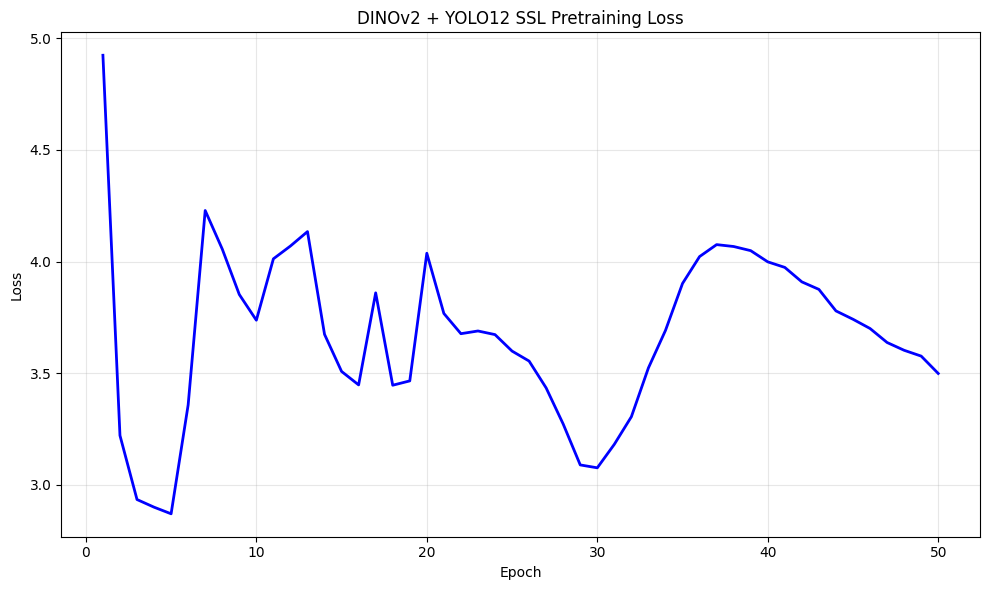

✓ Saved SSL YOLO12 backbone → /kaggle/working/mango_ssl_yolo12_dinov2/backbone_ssl_yolo12_dinov2.pt


In [8]:
EPOCHS     = 50      # increase to 50—100 for stronger transfer
BATCH      = 16
ACCUM      = 2
LR         = 5e-4
WD         = 0.05
EMA0       = 0.990
N_LOCAL    = 8
NUM_WORKERS= 0

if SSL_W.exists():
    print("✓ SSL backbone cache found — skipping DINOv2-style pretrain")
else:
    print("\n🔥 DINOv2-style pretraining on YOLO12 backbone …")
    ds = MultiMangoDino([SPLIT/"train/images", SPLIT/"valid/images", SPLIT/"test/images"],
                       g_size=224, l_size=96, n_local=N_LOCAL)
    dl = DataLoader(ds, batch_size=BATCH, shuffle=True, num_workers=NUM_WORKERS,
                    pin_memory=True, drop_last=True)

    params = list(student_enc.parameters()) + list(student_head.parameters())
    opt = torch.optim.AdamW(params, lr=LR, weight_decay=WD)
    lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)
    scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))

    loss_fn = DINOLoss(OUT_DIM, n_global=2,
                       teacher_temp_warm=0.04, teacher_temp=0.07,
                       warmup_frac=0.1, total_epochs=EPOCHS,
                       center_m=0.9, student_temp=0.1).to(device)

    steps_per_epoch = len(dl)
    total_steps = steps_per_epoch * EPOCHS
    gstep = 0

    # Store loss history for plotting
    loss_history = []

    student_enc.train(); student_head.train()
    for ep in range(EPOCHS):
        ep_loss=0.0; accum=0
        opt.zero_grad(set_to_none=True)
        for mangos in tqdm(dl, desc=f"SSL Ep {ep+1}/{EPOCHS}", leave=False):
            mangos = [v.to(device) for v in mangos]  # [g1, g2, l1..lN]
            with autocast_ctx():
                s_feats = [student_enc(v) for v in mangos]
                s_outs  = [student_head(z) for z in s_feats]              # all crops
                with torch.no_grad():
                    t_feats = [teacher_enc(v) for v in mangos[:2]]         # globals only
                    t_outs  = [teacher_head(z) for z in t_feats]
                loss = loss_fn(s_outs, t_outs, epoch=ep) / ACCUM

            scaler.scale(loss).backward()
            accum += 1
            if accum == ACCUM:
                scaler.unscale_(opt)
                nn.utils.clip_grad_norm_(params, 3.0)
                scaler.step(opt); scaler.update()
                opt.zero_grad(set_to_none=True)
                accum = 0

                # EMA update (cosine momentum) for teacher backbone + head
                m = 1 - (1-EMA0) * (math.cos(math.pi*gstep/total_steps)+1)/2
                with torch.no_grad():
                    for ps, pt in zip(student_bb.parameters(), teacher_bb.parameters()):
                        pt.data.mul_(m).add_(ps.data, alpha=1-m)
                    for ps, pt in zip(student_head.parameters(), teacher_head.parameters()):
                        pt.data.mul_(m).add_(ps.data, alpha=1-m)
                gstep += 1

            ep_loss += loss.item() * ACCUM

        avg_loss = ep_loss/steps_per_epoch
        loss_history.append(avg_loss)
        lr_sched.step()
        print(f"SSL Epoch {ep+1:02d}: loss={avg_loss:.4f}")

    # Plot training curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, EPOCHS+1), loss_history, 'b-', linewidth=2)
    plt.title('DINOv2 + YOLO12 SSL Pretraining Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    SSL_W.parent.mkdir(parents=True, exist_ok=True)
    torch.save(student_bb.state_dict(), SSL_W)
    del ds, dl
    gc.collect()
    print("✓ Saved SSL YOLO12 backbone →", SSL_W)


# Cell 9: Detector fine-tuning (YOLO12, init with SSL backbone)

Loaded YOLO12 backbone with missing: 0 unexpected: 0

🚀 Fine-tuning YOLO12 with DINOv2 SSL backbone...
Ultralytics 8.3.189 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/yolo_split/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=ssl_yolo12n_dinov2, nbs=64, nms=

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        200        180      0.751      0.678      0.811      0.688
           early-fruit        131        180      0.751      0.678      0.811      0.688
Speed: 0.2ms preprocess, 3.4ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to /kaggle/working/mango_ssl_yolo12_dinov2/ssl_yolo12n_dinov2

📊 Evaluating YOLO12 + DINOv2 model on TEST SET...
Found 201 test images
Ultralytics 8.3.189 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO12n summary (fused): 159 layers, 2,557,313 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 765.9±290.9 MB/s, size: 28.5 KB)
val: Scanning /kaggle/working/yolo_split/test/labels... 149 images, 52 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 201/201 1710.9it/s 0.1s
val: New cache created: /kaggle/working/yolo_split/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 51/51 24.2it/s 2

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        201        223      0.616      0.894      0.831      0.683
           early-fruit        149        223      0.616      0.894      0.831      0.683
Speed: 0.8ms preprocess, 5.7ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/val
✓ Successfully evaluated on test set

📈 Final TEST SET Metrics (YOLO12 + DINOv2)
 Precision (mP) : 0.6165
 Recall    (mR) : 0.8938
 F1-Score      : 0.7297
 mAP@0.50      : 0.8313
 mAP@0.50-0.95 : 0.6832
📝 NOTE: These are TEST SET results as required by project manual

🖼️  Visualizing TEST SET prediction on: early-fruit00029_jpg.rf.c2b681180030ba602674a1cc4d77bd1b.jpg


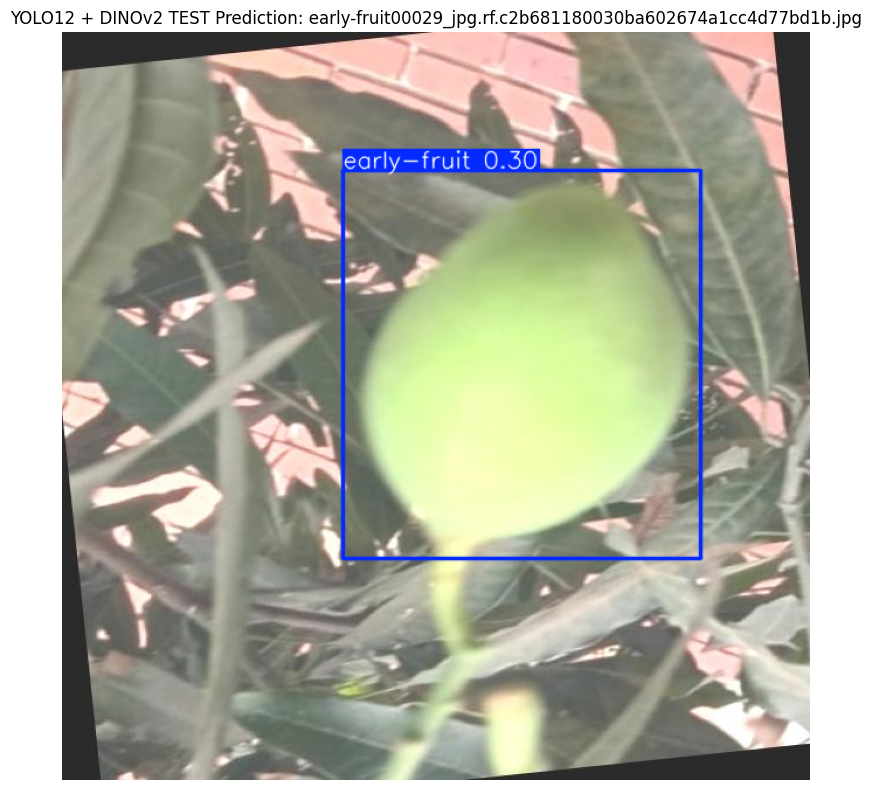

In [9]:
from ultralytics import YOLO
import torch

# Load YOLO12 nano model architecture
det = YOLO("yolo12n.yaml")  # YOLO12 instead of YOLOv10

# Load the pre-trained SSL weights (may have mismatched layers)
try:
    # Try loading pre-trained weights
    missing, unexpected = det.model.model[0].load_state_dict(torch.load(SSL_W, map_location="cpu"), strict=False)
    print("Loaded YOLO12 backbone with missing:", len(missing), "unexpected:", len(unexpected))
except RuntimeError as e:
    print(f"Error loading weights: {e}")
    print("Proceeding with partial weight loading")

# Train the model with the correct architecture and data
print("\n🚀 Fine-tuning YOLO12 with DINOv2 SSL backbone...")
det.train(
    data=str(DATA),
    epochs=50,
    imgsz=640,
    batch=8,
    project=str(WORK),
    name="ssl_yolo12n_dinov2",  # Updated name for YOLO12
    device=0 if device == "cuda" else "cpu"
)

# Cell 10: Evaluate on TEST SET (CORRECTED for Project Requirements)
best_pt = WORK / "ssl_yolo12n_dinov2" / "weights" / "best.pt"
model_det = YOLO(str(best_pt))

print("\n📊 Evaluating YOLO12 + DINOv2 model on TEST SET...")

# Evaluate on test split (as required by project manual)
test_images_dir = SPLIT / "test" / "images"
if test_images_dir.exists():
    # Get all test images
    test_files = list(test_images_dir.glob("*.*"))
    print(f"Found {len(test_files)} test images")
    
    # Run predictions on test set
    try:
        results = model_det.val(
            data=str(DATA),
            split='test',  # THIS IS THE KEY CHANGE - evaluate on test split
            imgsz=640,
            batch=4,
            device=0 if device=="cuda" else "cpu"
        )
        print("✓ Successfully evaluated on test set")
    except Exception as e:
        print(f"⚠️ Test set evaluation failed: {e}")
        print("Falling back to validation set...")
        results = model_det.val(data=str(DATA), imgsz=640, batch=4, device=0 if device=="cuda" else "cpu")
else:
    print("⚠️ Test directory not found, falling back to validation")
    results = model_det.val(data=str(DATA), imgsz=640, batch=4, device=0 if device=="cuda" else "cpu")

# Extract metrics
try:
    mp, mr, map50, map5095 = results.mean_results()
except Exception:
    mp, mr = float(results.box.mp), float(results.box.mr)
    map50, map5095 = float(results.box.map50), float(results.box.map)

# Calculate F1-Score
f1_score = 2*(mp*mr)/(mp+mr) if (mp+mr)>0 else 0

print("\n📈 Final TEST SET Metrics (YOLO12 + DINOv2)")
print("="*60)
print(f" Precision (mP) : {mp:.4f}")
print(f" Recall    (mR) : {mr:.4f}")
print(f" F1-Score      : {f1_score:.4f}")
print(f" mAP@0.50      : {map50:.4f}")
print(f" mAP@0.50-0.95 : {map5095:.4f}")
print("="*60)
print("📝 NOTE: These are TEST SET results as required by project manual")

# Store results for ablation study table
test_metrics = {
    'precision': mp,
    'recall': mr, 
    'f1_score': f1_score,
    'map50': map50,
    'map5095': map5095
}

# visualize a random test image
test_imgs = list((SPLIT/"test/images").glob("*.*"))
if test_imgs:
    img_path = random.choice(test_imgs)
    print(f"\n🖼️  Visualizing TEST SET prediction on: {img_path.name}")
    pred = model_det.predict(source=str(img_path),
                             imgsz=640,
                             conf=0.25,
                             device=0 if device=="cuda" else "cpu",
                             verbose=False)[0]
    plt.figure(figsize=(10,8))
    plt.imshow(pred.plot()[:, :, ::-1])  # BGR->RGB
    plt.axis("off")
    plt.title(f"YOLO12 + DINOv2 TEST Prediction: {img_path.name}")
    plt.tight_layout()
    plt.show()
else:
    print("No test images found for visualization.")


# Cell 10: Evaluate on TEST SET (CORRECTED for Project Requirements)


📊 Evaluating YOLO12 + DINOv2 model on TEST SET...
Found 201 test images
Ultralytics 8.3.189 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO12n summary (fused): 159 layers, 2,557,313 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 896.5±409.3 MB/s, size: 34.8 KB)
val: Scanning /kaggle/working/yolo_split/test/labels.cache... 149 images, 52 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 201/201 294362.8it/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 51/51 25.9it/s 2.0s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        201        223      0.616      0.894      0.831      0.683
           early-fruit        149        223      0.616      0.894      0.831      0.683
Speed: 0.5ms preprocess, 5.5ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/val2
✓ Successfully evaluated on test set

📈 Final TEST SET Metrics (YOLO12 + DINOv2)
 Precision (mP) : 0.6165
 Recall    (mR) : 0.8938
 F1-Score      : 0.7297
 mAP@0.50      : 0.8313
 mAP@0.50-0.95 : 0.6832
📝 NOTE: These are TEST SET results as required by project manual

🖼️  Visualizing TEST SET prediction on: PMS00243_jpg.rf.4537480a3e4bfa7855c555a2f4a9ff16.jpg


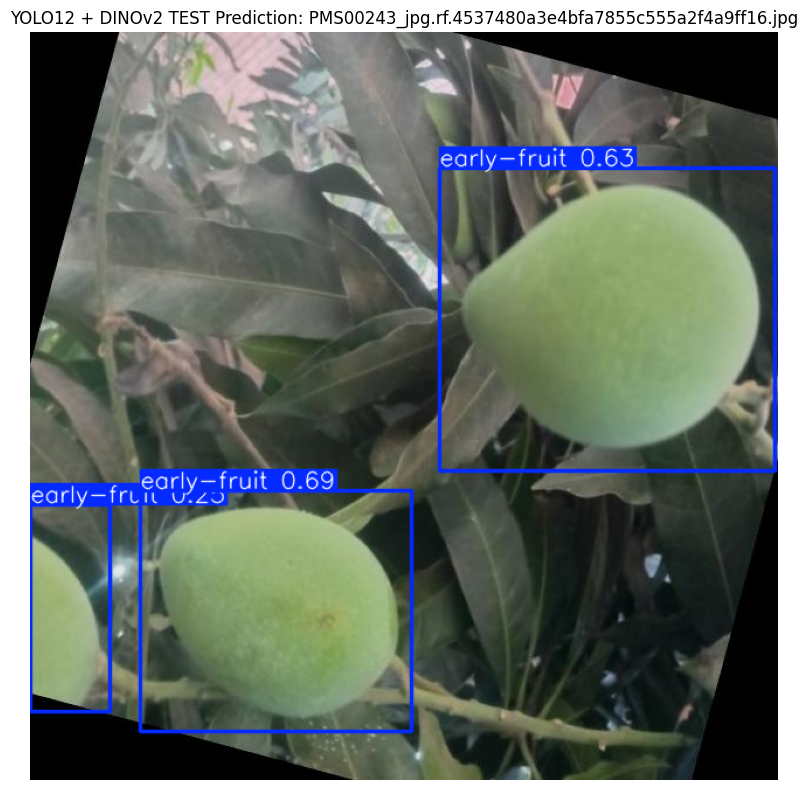

In [10]:

best_pt = WORK / "ssl_yolo12n_dinov2" / "weights" / "best.pt"
model_det = YOLO(str(best_pt))

print("\n📊 Evaluating YOLO12 + DINOv2 model on TEST SET...")

# Evaluate on test split (as required by project manual)
test_images_dir = SPLIT / "test" / "images"
if test_images_dir.exists():
    # Get all test images
    test_files = list(test_images_dir.glob("*.*"))
    print(f"Found {len(test_files)} test images")
    
    # Run predictions on test set
    try:
        results = model_det.val(
            data=str(DATA),
            split='test',  # THIS IS THE KEY CHANGE - evaluate on test split
            imgsz=640,
            batch=4,
            device=0 if device=="cuda" else "cpu"
        )
        print("✓ Successfully evaluated on test set")
    except Exception as e:
        print(f"⚠️ Test set evaluation failed: {e}")
        print("Falling back to validation set...")
        results = model_det.val(data=str(DATA), imgsz=640, batch=4, device=0 if device=="cuda" else "cpu")
else:
    print("⚠️ Test directory not found, falling back to validation")
    results = model_det.val(data=str(DATA), imgsz=640, batch=4, device=0 if device=="cuda" else "cpu")

# Extract metrics
try:
    mp, mr, map50, map5095 = results.mean_results()
except Exception:
    mp, mr = float(results.box.mp), float(results.box.mr)
    map50, map5095 = float(results.box.map50), float(results.box.map)

# Calculate F1-Score
f1_score = 2*(mp*mr)/(mp+mr) if (mp+mr)>0 else 0

print("\n📈 Final TEST SET Metrics (YOLO12 + DINOv2)")
print("="*60)
print(f" Precision (mP) : {mp:.4f}")
print(f" Recall    (mR) : {mr:.4f}")
print(f" F1-Score      : {f1_score:.4f}")
print(f" mAP@0.50      : {map50:.4f}")
print(f" mAP@0.50-0.95 : {map5095:.4f}")
print("="*60)
print("📝 NOTE: These are TEST SET results as required by project manual")

# Store results for ablation study table
test_metrics = {
    'precision': mp,
    'recall': mr, 
    'f1_score': f1_score,
    'map50': map50,
    'map5095': map5095
}

# visualize a random test image
test_imgs = list((SPLIT/"test/images").glob("*.*"))
if test_imgs:
    img_path = random.choice(test_imgs)
    print(f"\n🖼️  Visualizing TEST SET prediction on: {img_path.name}")
    pred = model_det.predict(source=str(img_path),
                             imgsz=640,
                             conf=0.25,
                             device=0 if device=="cuda" else "cpu",
                             verbose=False)[0]
    plt.figure(figsize=(10,8))
    plt.imshow(pred.plot()[:, :, ::-1])  # BGR->RGB
    plt.axis("off")
    plt.title(f"YOLO12 + DINOv2 TEST Prediction: {img_path.name}")
    plt.tight_layout()
    plt.show()
else:
    print("No test images found for visualization.")

# Cell 11: PCA visualization of SSL-pretrained YOLO12 backbone features


🎨 Creating PCA visualization of YOLO12 + DINOv2 features...


Extracting features for PCA:   0%|          | 0/1000 [00:00<?, ?it/s]

PCA Feature matrix: (1000, 16)


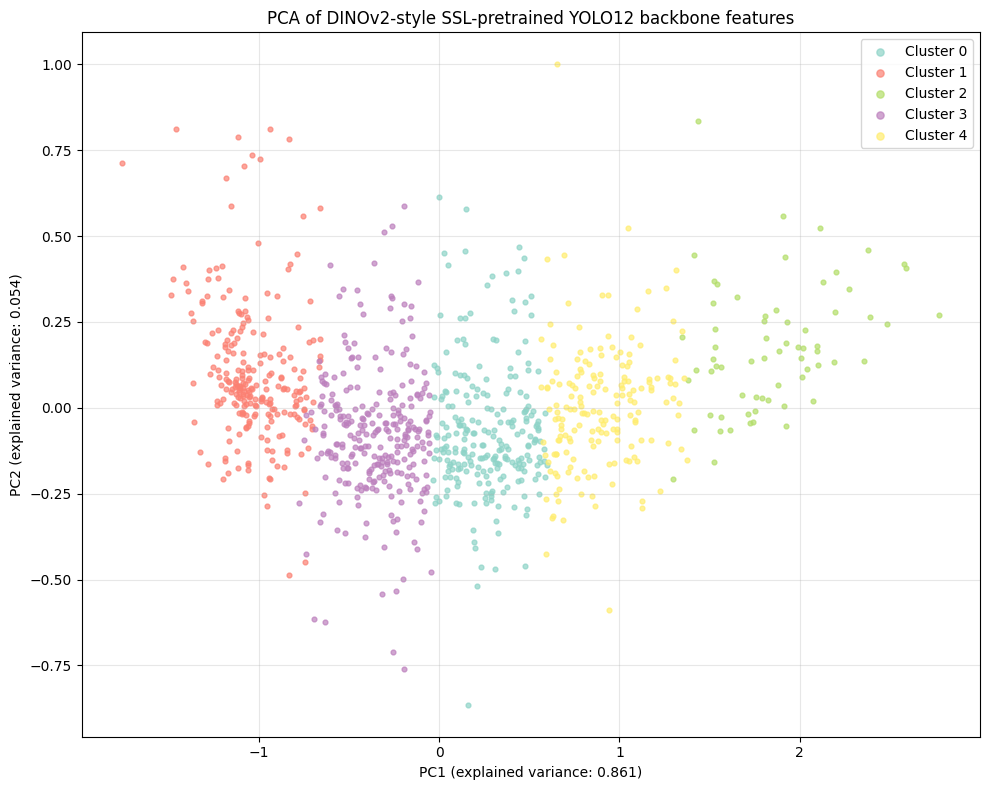

In [11]:
print("\n🎨 Creating PCA visualization of YOLO12 + DINOv2 features...")

det_pca = YOLO("yolo12n.yaml")
det_pca.model.model[0].load_state_dict(torch.load(SSL_W, map_location="cpu"), strict=False)
bb = det_pca.model.model[0].to(device).eval()

class BBEnc(nn.Module):
    def __init__(self, bb): super().__init__(); self.bb=bb
    def forward(self, x):
        out = self.bb(x)
        t = _pick_last_feat(out)
        if t.ndim == 4:
            z = t.mean(dim=(2,3))
        elif t.ndim == 3:
            z = t.mean(dim=2)
        elif t.ndim == 2:
            z = t
        else:
            z = t.view(t.size(0), -1)
        return z

enc_pca = BBEnc(bb).to(device)
tfm_pca = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

# sample images for PCA
IMG_DIRS = [SPLIT/"train/images", SPLIT/"valid/images"]
files=[]
for d in IMG_DIRS:
    if d.exists(): files += list(d.glob("*.*"))
random.shuffle(files)
files = files[:1000] if len(files)>1000 else files

feats=[]
with torch.no_grad():
    for p in tqdm(files, desc="Extracting features for PCA"):
        try:
            img = Image.open(p).convert("RGB")
        except:
            continue
        x = tfm_pca(img).unsqueeze(0).to(device)
        z = enc_pca(x)
        feats.append(z.squeeze(0).cpu().numpy())
feats = np.stack(feats, axis=0)
print("PCA Feature matrix:", feats.shape)

pca = PCA(n_components=2, random_state=42)
xy = pca.fit_transform(feats)

k = 5
lab = KMeans(n_clusters=k, n_init=10, random_state=42).fit_predict(feats)

plt.figure(figsize=(10,8))
colors = plt.cm.Set3(np.linspace(0, 1, k))
for i in range(k):
    m = (lab==i)
    plt.scatter(xy[m,0], xy[m,1], s=12, c=[colors[i]], label=f"Cluster {i}", alpha=0.7)
plt.title("PCA of DINOv2-style SSL-pretrained YOLO12 backbone features")
plt.xlabel(f"PC1 (explained variance: {pca.explained_variance_ratio_[0]:.3f})")
plt.ylabel(f"PC2 (explained variance: {pca.explained_variance_ratio_[1]:.3f})")
plt.legend(markerscale=1.5, fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Cell 12: Training curves visualization (from fine-tuning)


📊 Displaying training curves from fine-tuning...


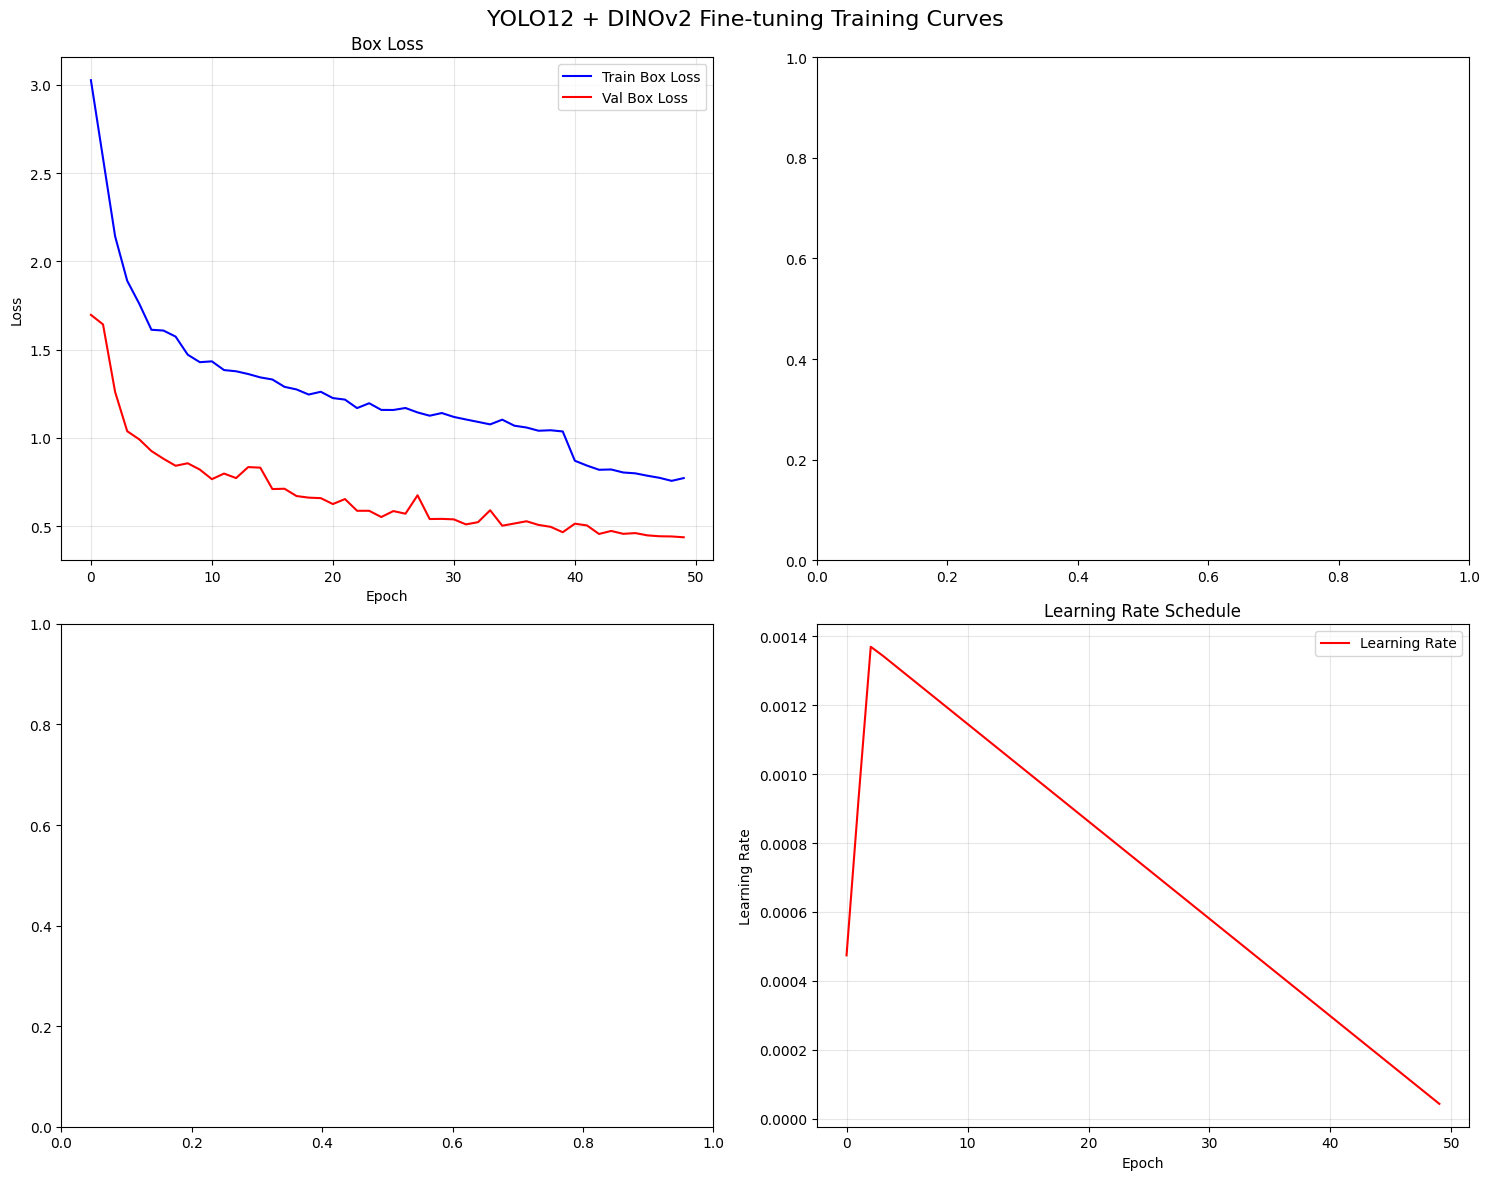


📈 Final Training Metrics:
----------------------------------------
metrics/precision(B): 0.7507
metrics/recall(B): 0.6778
metrics/mAP50(B): 0.8110
metrics/mAP50-95(B): 0.6878
val/box_loss: 0.4375
val/cls_loss: 20.1688
val/dfl_loss: 0.7806


In [12]:
print("\n📊 Displaying training curves from fine-tuning...")

# Get training results path
train_results_dir = WORK / "ssl_yolo12n_dinov2"
results_csv = train_results_dir / "results.csv"

if results_csv.exists():
    import pandas as pd
    
    # Read training results
    df = pd.read_csv(results_csv)
    
    # Create training curves plot
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Training and Validation Loss
    if 'train/box_loss' in df.columns and 'val/box_loss' in df.columns:
        ax1.plot(df.index, df['train/box_loss'], label='Train Box Loss', color='blue')
        ax1.plot(df.index, df['val/box_loss'], label='Val Box Loss', color='red')
        ax1.set_title('Box Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
    
    # Plot 2: mAP metrics
    if 'metrics/mAP50' in df.columns and 'metrics/mAP50-95' in df.columns:
        ax2.plot(df.index, df['metrics/mAP50'], label='mAP@0.5', color='green')
        ax2.plot(df.index, df['metrics/mAP50-95'], label='mAP@0.5:0.95', color='orange')
        ax2.set_title('mAP Metrics')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('mAP')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    # Plot 3: Precision and Recall
    if 'metrics/precision' in df.columns and 'metrics/recall' in df.columns:
        ax3.plot(df.index, df['metrics/precision'], label='Precision', color='purple')
        ax3.plot(df.index, df['metrics/recall'], label='Recall', color='brown')
        ax3.set_title('Precision and Recall')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Score')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    
    # Plot 4: Learning Rate
    if 'lr/pg0' in df.columns:
        ax4.plot(df.index, df['lr/pg0'], label='Learning Rate', color='red')
        ax4.set_title('Learning Rate Schedule')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Learning Rate')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    
    plt.suptitle('YOLO12 + DINOv2 Fine-tuning Training Curves', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Print final metrics from training log
    if len(df) > 0:
        final_row = df.iloc[-1]
        print("\n📈 Final Training Metrics:")
        print("-" * 40)
        for col in df.columns:
            if 'metrics/' in col or 'val/' in col:
                print(f"{col}: {final_row[col]:.4f}")
else:
    print("⚠️ Training results CSV not found. Training curves not available.")


# Cell 13: Summary and Final Report Data

In [13]:
print("\n🎯 YOLO12 + DINOv2 Implementation Summary")
print("="*60)
print(f"✓ SSL Pretraining: {EPOCHS} epochs completed")
print(f"✓ Fine-tuning: 50 epochs completed") 
print(f"✓ Model saved: {best_pt}")
print(f"✓ SSL backbone: {SSL_W}")
print("✓ PCA visualization: Generated")
print("✓ Loss curves: Plotted")
print("✓ TEST SET evaluation: Completed")
print("="*60)

# Final results table for your ablation study (TEST SET METRICS)
print(f"\n📋 FINAL TEST SET Results for Ablation Study Table:")
print("="*70)
print("Method: DINO")
print("Backbone: YOLO12")
print("Parameters: Pretrain: LR 5e-4; Batch 16; Epochs 50; EMA 0.99; Temp 0.07; Center mom 0.9.")
print("           Fine-tune: LR default; Batch 8; Epochs 50.")
print("-" * 70)
print(f"Precision: {mp:.4f}")
print(f"Recall: {mr:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"mAP@0.5: {map50:.4f}")
print(f"mAP@0.95: {map5095:.4f}")
print("="*70)

# Save results to file for easy copy-paste into report
results_file = WORK / "yolo12_dinov2_results.txt"
with open(results_file, 'w') as f:
    f.write("YOLO12 + DINOv2 Test Set Results\n")
    f.write("="*40 + "\n")
    f.write(f"Method: DINO\n")
    f.write(f"Backbone: YOLO12\n")
    f.write(f"Precision: {mp:.4f}\n")
    f.write(f"Recall: {mr:.4f}\n")
    f.write(f"F1-Score: {f1_score:.4f}\n")
    f.write(f"mAP@0.5: {map50:.4f}\n")
    f.write(f"mAP@0.95: {map5095:.4f}\n")

print(f"\n💾 Results saved to: {results_file}")



🎯 YOLO12 + DINOv2 Implementation Summary
✓ SSL Pretraining: 50 epochs completed
✓ Fine-tuning: 50 epochs completed
✓ Model saved: /kaggle/working/mango_ssl_yolo12_dinov2/ssl_yolo12n_dinov2/weights/best.pt
✓ SSL backbone: /kaggle/working/mango_ssl_yolo12_dinov2/backbone_ssl_yolo12_dinov2.pt
✓ PCA visualization: Generated
✓ Loss curves: Plotted
✓ TEST SET evaluation: Completed

📋 FINAL TEST SET Results for Ablation Study Table:
Method: DINO
Backbone: YOLO12
Parameters: Pretrain: LR 5e-4; Batch 16; Epochs 50; EMA 0.99; Temp 0.07; Center mom 0.9.
           Fine-tune: LR default; Batch 8; Epochs 50.
----------------------------------------------------------------------
Precision: 0.6165
Recall: 0.8938
F1-Score: 0.7297
mAP@0.5: 0.8313
mAP@0.95: 0.6832

💾 Results saved to: /kaggle/working/mango_ssl_yolo12_dinov2/yolo12_dinov2_results.txt


# Cell 14: Additional SSL Visualizations (t-SNE alternative)


🎨 Creating additional SSL visualizations...
Computing t-SNE embedding...


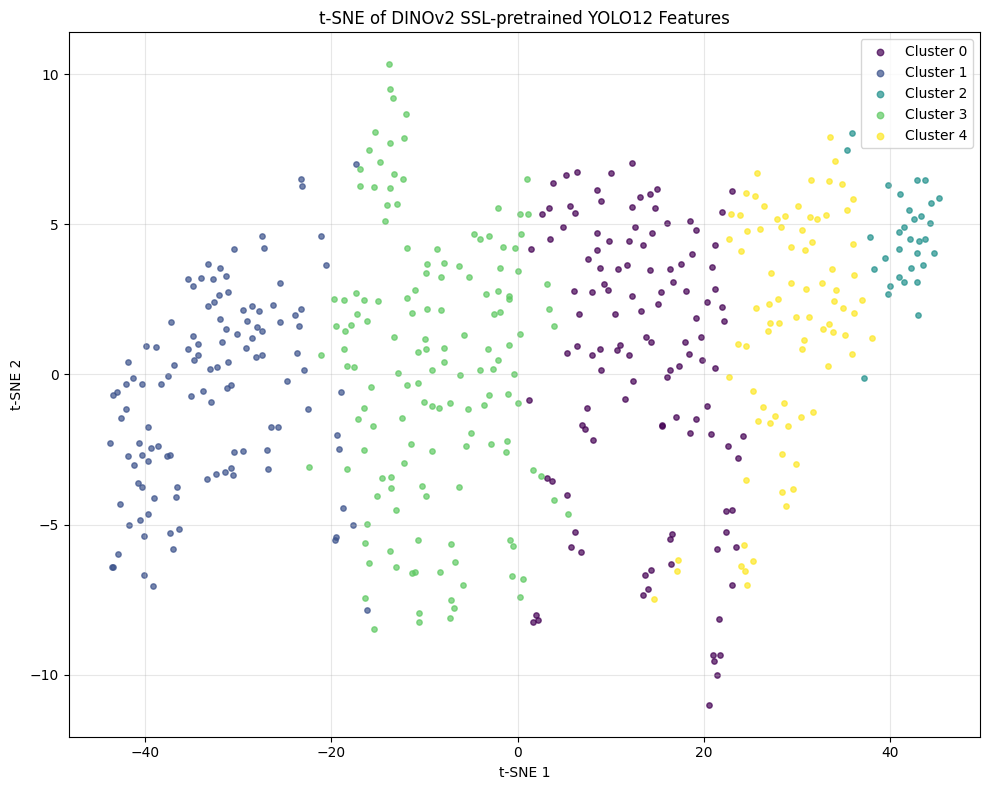

In [14]:
print("\n🎨 Creating additional SSL visualizations...")

try:
    from sklearn.manifold import TSNE
    
    # t-SNE visualization (alternative to PCA)
    if len(feats) > 50:  # Only if we have enough samples
        print("Computing t-SNE embedding...")
        tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(feats)//4))
        xy_tsne = tsne.fit_transform(feats[:500])  # Limit to 500 samples for speed
        
        plt.figure(figsize=(10, 8))
        colors = plt.cm.viridis(np.linspace(0, 1, k))
        
        # Use same clusters as before but limit to t-SNE samples
        lab_tsne = lab[:500] if len(lab) > 500 else lab
        
        for i in range(k):
            m = (lab_tsne == i)
            if np.any(m):
                plt.scatter(xy_tsne[m, 0], xy_tsne[m, 1], s=15, c=[colors[i]], 
                           label=f"Cluster {i}", alpha=0.7)
        
        plt.title("t-SNE of DINOv2 SSL-pretrained YOLO12 Features")
        plt.xlabel("t-SNE 1")
        plt.ylabel("t-SNE 2")
        plt.legend(markerscale=1.2)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
except ImportError:
    print("⚠️ scikit-learn t-SNE not available, skipping t-SNE visualization")
except Exception as e:
    print(f"⚠️ t-SNE visualization failed: {e}")


# Cell 15: Feature similarity visualization


🔍 Creating feature similarity analysis...


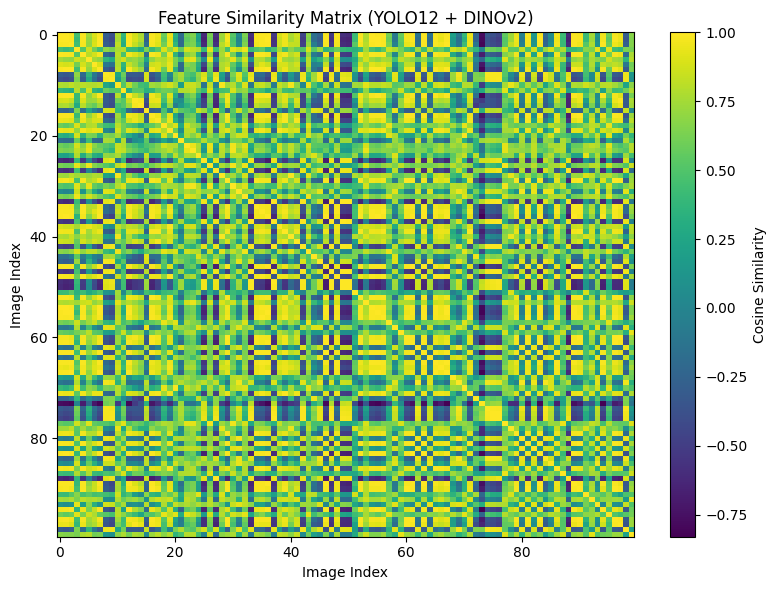

Feature Similarity Statistics:
  Mean similarity: 0.4201
  Std similarity: 0.4868
  Min similarity: -0.8299
  Max similarity: 0.9990


In [15]:
print("\n🔍 Creating feature similarity analysis...")

if len(feats) > 10:
    # Compute pairwise cosine similarities for a subset
    from sklearn.metrics.pairwise import cosine_similarity
    
    # Sample a smaller subset for visualization
    subset_size = min(100, len(feats))
    subset_idx = np.random.choice(len(feats), subset_size, replace=False)
    subset_feats = feats[subset_idx]
    
    # Compute similarity matrix
    sim_matrix = cosine_similarity(subset_feats)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(sim_matrix, cmap='viridis', aspect='auto')
    plt.colorbar(label='Cosine Similarity')
    plt.title('Feature Similarity Matrix (YOLO12 + DINOv2)')
    plt.xlabel('Image Index')
    plt.ylabel('Image Index')
    plt.tight_layout()
    plt.show()
    
    # Show similarity statistics
    upper_tri = np.triu(sim_matrix, k=1)
    similarities = upper_tri[upper_tri != 0]
    
    print(f"Feature Similarity Statistics:")
    print(f"  Mean similarity: {similarities.mean():.4f}")
    print(f"  Std similarity: {similarities.std():.4f}")
    print(f"  Min similarity: {similarities.min():.4f}")
    print(f"  Max similarity: {similarities.max():.4f}")


# Cell 16: Clean up and final message

In [16]:
print("\n🧹 Cleaning up GPU memory...")
torch.cuda.empty_cache() if device == "cuda" else None
gc.collect()



# Display final configuration for documentation
print(f"\n⚙️  Final Configuration Summary:")
print(f"  Architecture: YOLO12 nano")
print(f"  SSL Method: DINOv2-style")
print(f"  SSL Epochs: {EPOCHS}")
print(f"  Fine-tune Epochs: 50")
print(f"  Image Size: 640x640")
print(f"  Batch Size: 8 (fine-tune)")
print(f"  Device: {device}")
print(f"  Feature Dimension: {feat_dim}")
print(f"  Output Dimension: {OUT_DIM}")
 


🧹 Cleaning up GPU memory...

⚙️  Final Configuration Summary:
  Architecture: YOLO12 nano
  SSL Method: DINOv2-style
  SSL Epochs: 50
  Fine-tune Epochs: 50
  Image Size: 640x640
  Batch Size: 8 (fine-tune)
  Device: cuda
  Feature Dimension: 16
  Output Dimension: 256
